Group 3
Miquel Romero Blanch NIU 1528716
Josep Bravo Bravo NIU 1526453

In [1]:
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Read data
Let us first read the train and test files

In [2]:
def read_dataset():
    train_images_filenames = pickle.load(open('train_images_filenames.dat','rb'))
    test_images_filenames = pickle.load(open('test_images_filenames.dat','rb'))
    train_images_filenames = ['..' + n[15:] for n in train_images_filenames]
    test_images_filenames  = ['..' + n[15:] for n in test_images_filenames]
    train_labels = pickle.load(open('train_labels.dat','rb'))
    test_labels = pickle.load(open('test_labels.dat','rb'))
    images_filenames = np.array(train_images_filenames + test_images_filenames)
    labels = np.array(train_labels + test_labels)
    return images_filenames, labels

In [3]:
def read_train_test():
    train_images_filenames = pickle.load(open('train_images_filenames.dat','rb'))
    test_images_filenames = pickle.load(open('test_images_filenames.dat','rb'))
    train_images_filenames = ['..' + n[15:] for n in train_images_filenames]
    test_images_filenames  = ['..' + n[15:] for n in test_images_filenames]
    train_labels = pickle.load(open('train_labels.dat','rb'))
    test_labels = pickle.load(open('test_labels.dat','rb'))
    return train_images_filenames, test_images_filenames, train_labels, test_labels

# Descriptor
We create a KAZE/SIFT/.... object detector and descriptor

In [4]:
def compute_dense_keypoints(img, step):
    keypoints = []
    for i in range(step//2, img.shape[0], step):
        for j in range(step//2, img.shape[1], step):
            keypoints.append(cv2.KeyPoint(j, i, step))
    return keypoints

In [5]:
def dense_sift(img, keypoints, n_features=None):
    detector = cv2.SIFT_create(n_features)
    return detector.compute(img, keypoints)

def sift(img, n_features=None):
    detector = cv2.SIFT_create(n_features)
    return detector.detectAndCompute(img, None)

def kaze(img):
    detector = cv2.KAZE_create(threshold=0.0001)
    return detector.detectAndCompute(img, None)

def akaze(img):
    detector = cv2.AKAZE_create(threshold=0.0001)
    return detector.detectAndCompute(img, None)

def orb(img, n_features=None):
    detector = cv2.ORB_create(n_features)
    return detector.detectAndCompute(img, None)

Compute descriptors depending on specified type

In [6]:
def get_descriptor(im, des_type, step, n_features=None):
    if des_type == "DSIFT":  # Dense SIFT
        kpt = compute_dense_keypoints(im, step)
        kpt, des = dense_sift(im, kpt, n_features)
    elif des_type == "SIFT":
        kpt, des = sift(im, n_features)
    elif des_type == "KAZE":
        kpt, des = kaze(im)
    elif des_type == "AKAZE":
        kpt, des = akaze(im)
    elif des_type == "ORB":
        kpt, des = orb(im, n_features)
    return kpt, des

We compute the  descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together

In [7]:
def compute_descriptors(train_images_filenames, train_labels, des_type, step=None, n_features = None):
    Train_descriptors = []
    Train_label_per_descriptor = []
    for filename,labels in zip(train_images_filenames,train_labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        kpt,des=get_descriptor(gray, des_type, step, n_features=n_features)
        Train_descriptors.append(des)
        Train_label_per_descriptor.append(labels)
    D=np.vstack(Train_descriptors)
    return D, Train_descriptors

# Clustering
We now compute a k-means clustering on the descriptor space

In [8]:
def compute_codebook(D, k):
    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    codebook.fit(D)
    return codebook

And, for each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.

In [9]:
def compute_visual_words(codebook, Train_descriptors, k):
    visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
    for i in range(len(Train_descriptors)):
        words=codebook.predict(Train_descriptors[i])
        visual_words[i,:]=np.bincount(words,minlength=k)
    return visual_words

# Classifier
We build a k-nn classifier and train it with the train descriptors

In [10]:
def train(train_labels, visual_words, n, distance="euclidean"):
    knn = KNeighborsClassifier(n_neighbors=n,n_jobs=-1,metric=distance)
    knn.fit(visual_words, train_labels)
    return knn

We end up computing the test descriptors and compute the accuracy of the model

In [29]:
def test(test_images_filenames, test_labels, knn, codebook, k, des_type, step, plot_matrix = True, plot_prints = True):
    visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
    for i in range(len(test_images_filenames)):
        filename=test_images_filenames[i]
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        kpt,des=get_descriptor(gray, des_type, step)
        words=codebook.predict(des)
        visual_words_test[i,:]=np.bincount(words,minlength=k)
    accuracy = 100*knn.score(visual_words_test, test_labels)
    if plot_prints:   
        print(f"acc: {accuracy}")
    if plot_matrix:
        # Get confusion matrix
        predictions = knn.predict(visual_words_test)
        confusion_mat = confusion_matrix(test_labels, predictions)
        sns.heatmap(confusion_mat, annot=True)
        plt.show()
    return visual_words_test, accuracy

# Dimensionality reduction
Dimensionality reduction, with PCA and LDA

In [12]:
def test_pca(train_labels, test_labels, visual_words, visual_words_test, pca_components=64, n=5, distance="euclidean", plot_prints=True):
    pca = PCA(n_components=pca_components)
    VWpca = pca.fit_transform(visual_words)
    knnpca = KNeighborsClassifier(n_neighbors=n,n_jobs=-1,metric=distance)
    knnpca.fit(VWpca, train_labels)
    vwtestpca = pca.transform(visual_words_test)
    accuracy = 100*knnpca.score(vwtestpca, test_labels)
    if plot_prints:
        print(f"PCA reduction acc: {accuracy}")
    return accuracy

In [13]:
def test_lda(train_labels, test_labels, visual_words, visual_words_test, lda_components=7, n=5, distance="euclidean", plot_prints=True):
    lda = LinearDiscriminantAnalysis(n_components=lda_components)
    VWlda = lda.fit_transform(visual_words,train_labels)
    knnlda = KNeighborsClassifier(n_neighbors=n,n_jobs=-1,metric=distance)
    knnlda.fit(VWlda, train_labels)
    vwtestlda = lda.transform(visual_words_test)
    accuracy = 100*knnlda.score(vwtestlda, test_labels)
    if plot_prints:    
        print(f"LDA reduction acc: {accuracy}")
    return accuracy

# Experiments

In [14]:
des_type = "SIFT"  # "SIFT", "DSIFT", "KAZE", 'ORB', 'AKAZE'
step = 4  # every STEP pixels a descriptor is computed, lower values imply more keypoints/descriptors
k_codebook = 128
n_neighbours = 5
knn_distance = "euclidean" # ‘manhattan’, ‘cosine’
pca_components = 64
lda_components = 7
n_features = None #None for all features

Execute experiment with train and test provided

In [30]:
train_images_filenames, test_images_filenames, train_labels, test_labels = read_train_test()

def train_and_test(plot_matrix=True, plot_prints=True):
    # TRAIN
    D, Train_descriptors = compute_descriptors(train_images_filenames, train_labels, des_type, step, n_features)
    codebook = compute_codebook(D, k_codebook)
    visual_words = compute_visual_words(codebook, Train_descriptors, k_codebook)
    knn = train(train_labels, visual_words, n_neighbours, knn_distance)
    # TEST
    visual_words_test, accuracy = test(test_images_filenames, test_labels, knn, codebook, k_codebook,  des_type, step, plot_matrix=plot_matrix, plot_prints=plot_prints)
    pca_accuracy = test_pca(train_labels, test_labels, visual_words, visual_words_test, pca_components, n_neighbours, knn_distance, plot_prints=plot_prints)
    lda_accuracy = test_lda(train_labels, test_labels, visual_words, visual_words_test, lda_components, n_neighbours, knn_distance, plot_prints=plot_prints)
    return accuracy, pca_accuracy, lda_accuracy, visual_words, visual_words_test

acc: 59.97521685254027


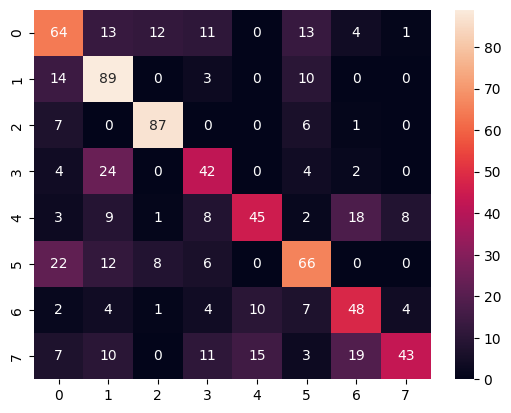

PCA reduction acc: 59.85130111524164
LDA reduction acc: 65.55142503097893


In [16]:
acc, pca_acc, lda_acc, visual_words, visual_words_test = train_and_test()

Test with different distances in the k-nn classifier:

Knn Distance used: euclidean
acc: 59.97521685254027


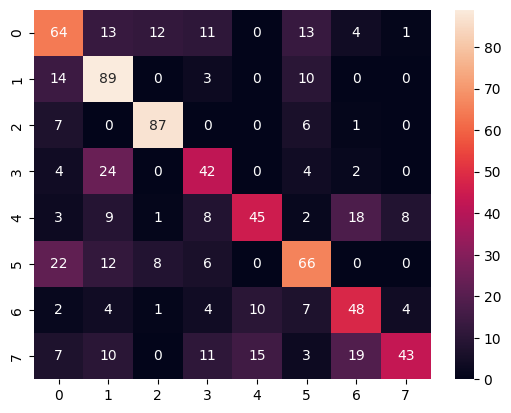

PCA reduction acc: 61.33828996282528
LDA reduction acc: 65.55142503097893
Knn Distance used: manhattan
acc: 58.116480793060724


PCA reduction acc: 56.62949194547707
LDA reduction acc: 65.05576208178438
Knn Distance used: cosine
acc: 60.594795539033456


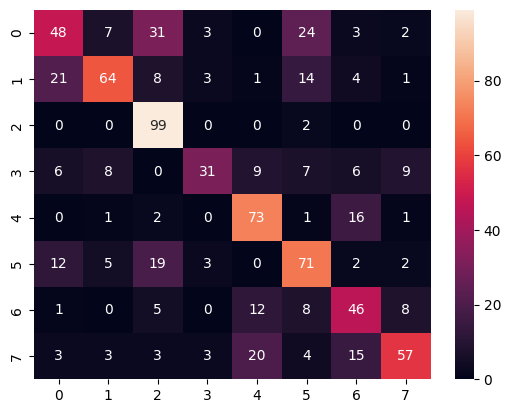

PCA reduction acc: 59.85130111524164
LDA reduction acc: 64.43618339529121


In [17]:
knn_distance_list = ["euclidean", "manhattan", "cosine"]
accuracies = []
pca_reductions = []
lda_reductions = []
for knn_distance in knn_distance_list:
    print("Knn Distance used: "+ knn_distance)
    acc, pca_acc, lda_acc, _, _ = train_and_test()
    accuracies.append(acc)
    pca_reductions.append(pca_acc)
    lda_reductions.append(lda_acc)

In [18]:
# Plot
fig, ax = plt.subplots()
ax.plot(knn_distance_list, accuracies, linestyle='None', marker='o', label='Accuracy')
ax.plot(knn_distance_list, pca_reductions, linestyle='None', marker='o', label='PCA reduction')
ax.plot(knn_distance_list, lda_reductions, linestyle='None', marker='o', label='LDA reduction')
ax.set_xlabel('Distance')
ax.set_ylabel('Accuracy')
ax.legend()
plt.grid()
plt.show()

**Test other distances in k-nn classifier. Does that make a difference? Why?**

If we don't take into account dimensionality reduction, cosine distances appear to be the best one. On the other hand, Euclidean distance is the best if LDA reduction is used. Also LDA reduction improves a lot the accuracy of all the different distances in a k-nn classifier, whereas PCA reduction just improves by 1% the accuracy of Euclidean and Manhattan distance, and scores worst accuracy on cosine distance.

Euclidean distance is the most common choice and is a good default option. It works well when the data is uniformly distributed and the features have the same scale.

Manhattan distance works well when the features have different scales and the data is not uniformly distributed, which is not our case, as we can see in both the data and the accuracy results (without dimensionality changes).

Cosine distance is also a good option, as it works with data that is represented in the form of vectors. It measures the similarity between two vectors based on the cosine of the angle between them, rather than the Euclidean distance between their components.


Test with different descriptors:

DESCRIPTOR: SIFT
acc: 60.594795539033456


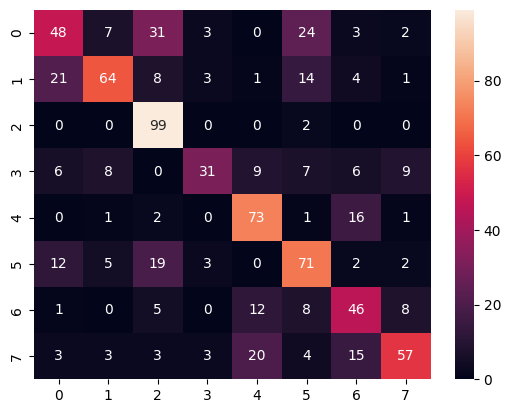

PCA reduction acc: 60.470879801734824
LDA reduction acc: 64.43618339529121
DESCRIPTOR: DSIFT
acc: 69.64064436183395


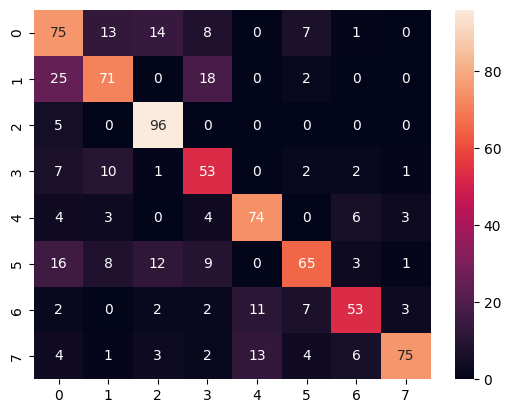

PCA reduction acc: 67.41016109045849
LDA reduction acc: 79.67781908302355
DESCRIPTOR: KAZE
acc: 56.25774473358116


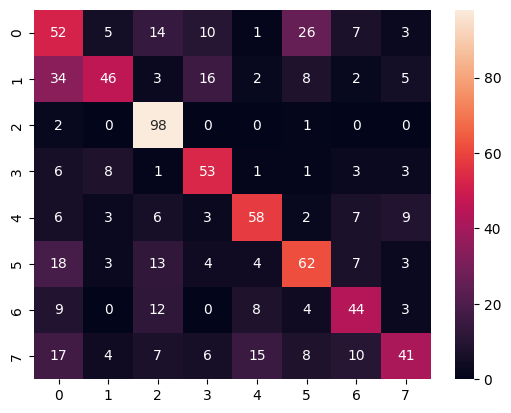

PCA reduction acc: 57.99256505576208
LDA reduction acc: 63.94052044609665
DESCRIPTOR: ORB
acc: 30.855018587360593


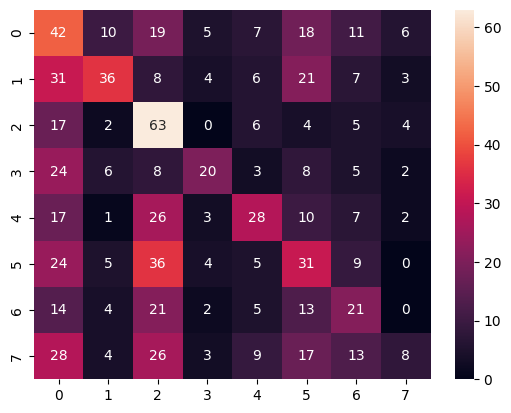

PCA reduction acc: 32.96158612143743
LDA reduction acc: 37.42255266418835
DESCRIPTOR: AKAZE
acc: 38.28996282527881


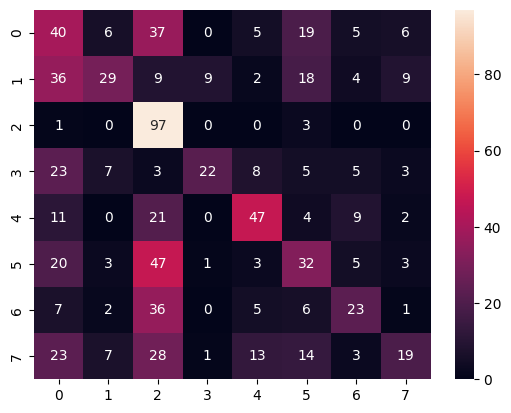

PCA reduction acc: 46.71623296158612
LDA reduction acc: 51.053283767038415


In [19]:
des_type_list = ["SIFT", "DSIFT", "KAZE", 'ORB', 'AKAZE']
accuracies = []
pca_reductions = []
lda_reductions = []
for des_type in des_type_list:
    print("DESCRIPTOR: "+ des_type)
    acc, pca_acc, lda_acc, _, _ = train_and_test()
    accuracies.append(acc)
    pca_reductions.append(pca_acc)
    lda_reductions.append(lda_acc)

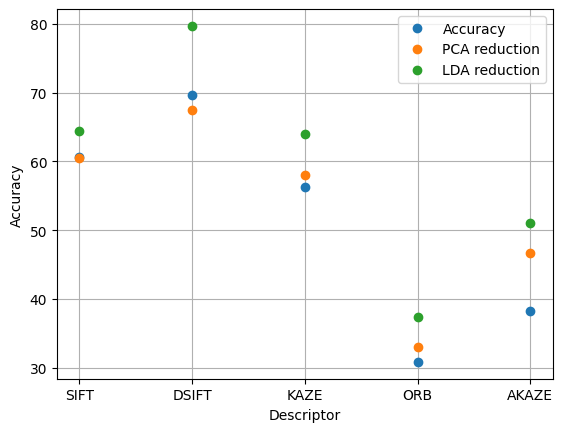

In [20]:
# Plot
fig, ax = plt.subplots()
ax.plot(des_type_list, accuracies, linestyle='None', marker='o', label='Accuracy')
ax.plot(des_type_list, pca_reductions, linestyle='None', marker='o', label='PCA reduction')
ax.plot(des_type_list, lda_reductions, linestyle='None', marker='o', label='LDA reduction')
ax.set_xlabel('Descriptor')
ax.set_ylabel('Accuracy')
ax.legend()
plt.grid()
plt.show()

**Use dense SIFT instead of detected keypoints. Conclusions?**

In our case we have tried the following descriptors to identify and match keypoints in images:

SIFT is invariant to image scaling, rotation, and affine distortion, and is robust to changes in illumination and partial occlusion. SIFT is widely used in computer vision and image processing applications.

DSIFT (Dense SIFT) is a variant of SIFT that computes SIFT features at a dense set of points across an image. This can be useful for tasks such as image classification, where it is often important to consider the overall layout and structure of an image, which is our case.

KAZE is a keypoint descriptor that is based on the KAZE image feature detector. It uses a diffusion process to identify stable keypoints, and is robust to noise and affine distortion.

ORB is a keypoint descriptor that is designed to be fast and efficient. It combines the FAST corner detector with the BRIEF descriptor, and is rotation invariant. ORB is often used in applications where real-time performance is important, which is not our case.

AKAZE (Accelerated KAZE) is another keypoint descriptor that is based on the KAZE feature detector. It uses an accelerated version of the KAZE diffusion process to identify stable keypoints, and is robust to noise and affine distortion. AKAZE is often used in applications where real-time performance is important.

As we can see in the explanation before, and the plot of the accuracies each of these descriptors has given, we can see that Dense SIFT is the best one for our application, being better than its predecessor, and way better than the rest, which are not dense, and more focused on being fast, for example for real-time applications.

To make image classification, in our case, all the features of an image are important, not just a corner, but objects, colors, etc., which is why DSIFT has proven to be the best. Nonetheless, it is way slower than the others.

# CrossValidation
Execute CrossValidation using a stratified k fold strategy

In [21]:
import pandas as pd

def plot_stratified_fold(train_labels, test_labels, fold):
    d = {}
    for label in train_labels:
        if label in d.keys():
            d[label] += 1
        else:
            d[label] = 1
    a=pd.DataFrame(d.items(), columns=['Label', 'Train'])
    d = {}
    for label in test_labels:
        if label in d.keys():
            d[label] += 1
        else:
            d[label] = 1
    b=pd.DataFrame(d.items(), columns=['Label', 'Test'])
    extracted_col = b['Test']
    a.insert(2, 'Test', extracted_col)
    a.plot(
    x = 'Label',
    kind = 'barh',
    stacked = True,
    title = f'Class population in fold {fold}',
    mark_right = True)
    plt.show()

Fold Nº 1/4


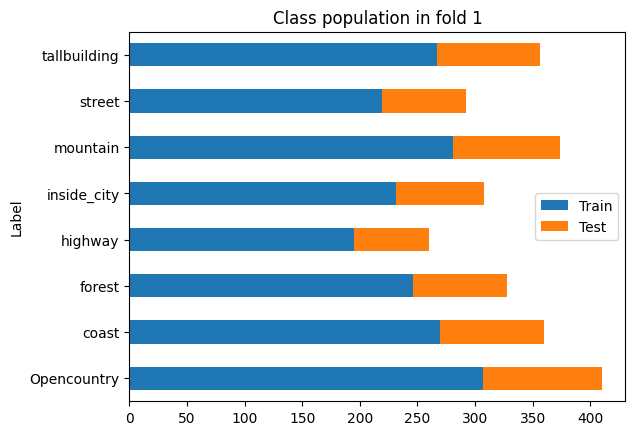

acc: 72.02380952380952


PCA reduction acc: 69.49404761904762
LDA reduction acc: 80.65476190476191
Fold Nº 2/4


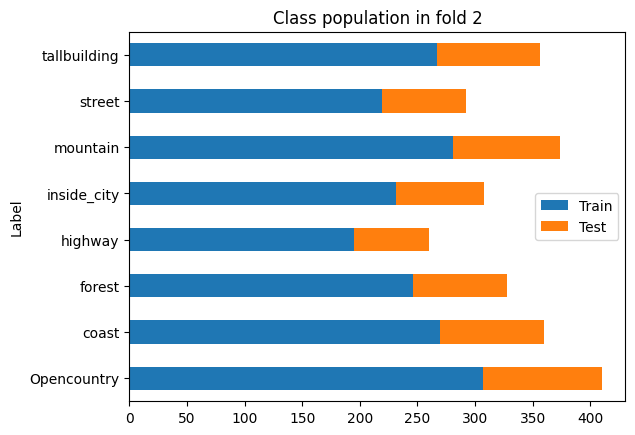

acc: 73.95833333333334


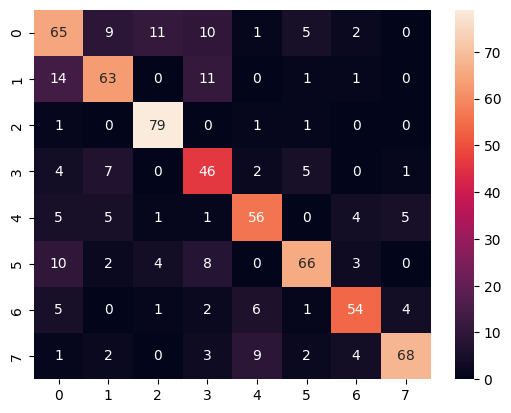

PCA reduction acc: 71.42857142857143
LDA reduction acc: 81.99404761904762
Fold Nº 3/4


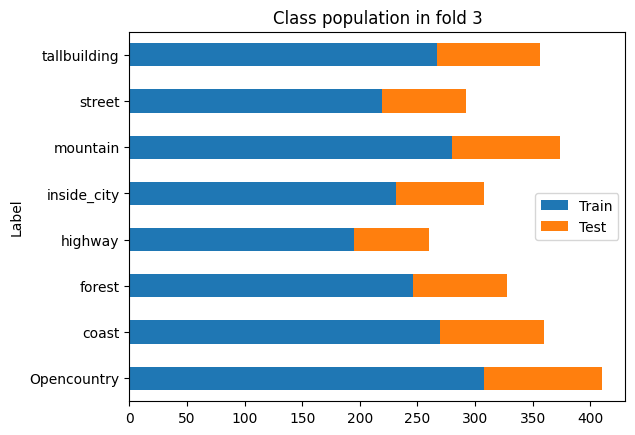

acc: 72.61904761904762


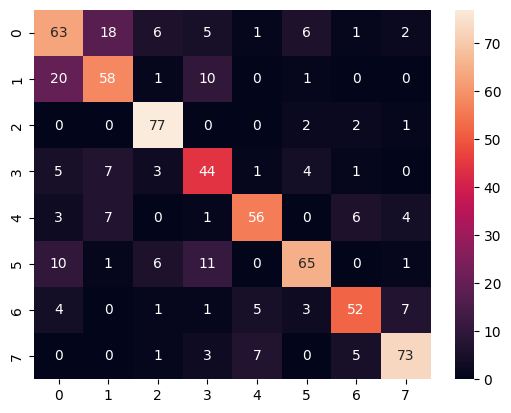

PCA reduction acc: 68.30357142857143
LDA reduction acc: 78.72023809523809
Fold Nº 4/4


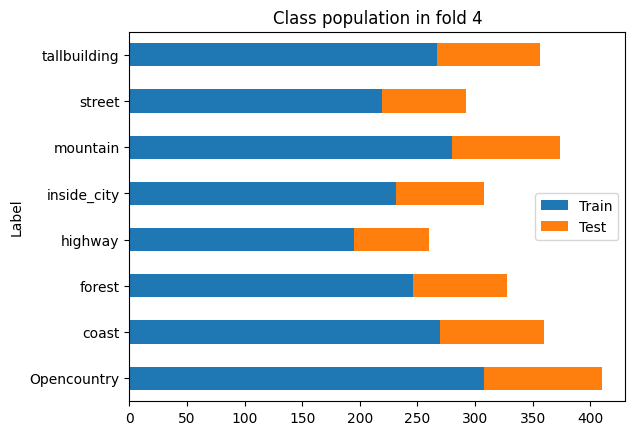

acc: 73.21428571428571


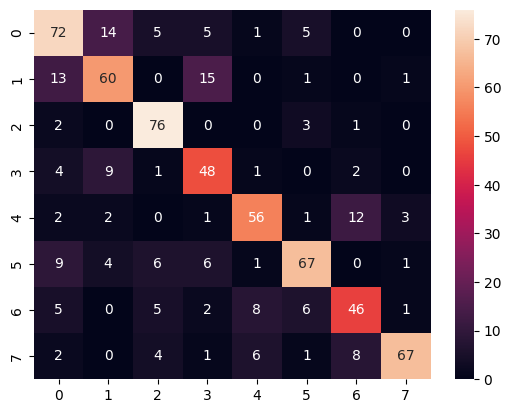

PCA reduction acc: 73.06547619047619
LDA reduction acc: 80.35714285714286


In [22]:
from sklearn.model_selection import StratifiedKFold

k_folds = 4
des_type = "DSIFT"
knn_distance = "cosine"

images_filenames, labels = read_dataset()

kfold = StratifiedKFold(n_splits=k_folds, shuffle=True)
for fold, (train_ids, test_ids) in enumerate(kfold.split(images_filenames, labels)):
    print(f'Fold Nº {fold+1}/{k_folds}')
    train_images_filenames, train_labels = images_filenames[train_ids], labels[train_ids]
    test_images_filenames, test_labels = images_filenames[test_ids], labels[test_ids]
    plot_stratified_fold(train_labels, test_labels, fold+1)
    train_and_test()

**Cross-validate everything**

In order to cross validate we have followed a stratified K fold strategy. Such strategy consists of using folds that always have the same percentage of train and test for every class, this way we ensure that every fold is balanced and bad results in one fold are not due to unbalanced sets.
It has been used a 4-fold cross validation, which means that in every fold it will be used a 75% of the dataset as train and the rest as test for every class.
The results prove that the model is consistent as the accuracy without dimensionality reduction and with PCA and LDA reduction always outputs very similar values in every fold.

# Plots

acc: 69.64064436183395


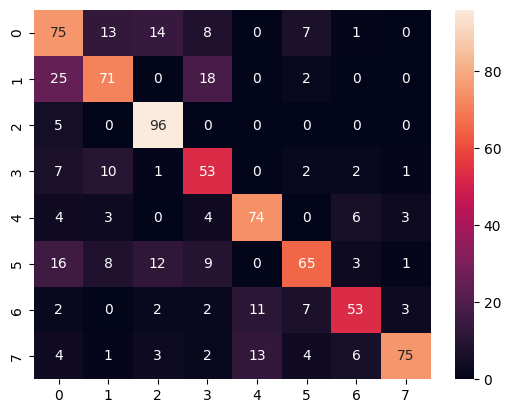

PCA reduction acc: 67.41016109045849
LDA reduction acc: 79.67781908302355


In [23]:
#reset back the original partition, not the cross-validation one.
train_images_filenames, test_images_filenames, train_labels, test_labels = read_train_test()
acc, pca_acc, lda_acc, visual_words, visual_words_test = train_and_test()

Play with reducing dimensionality:

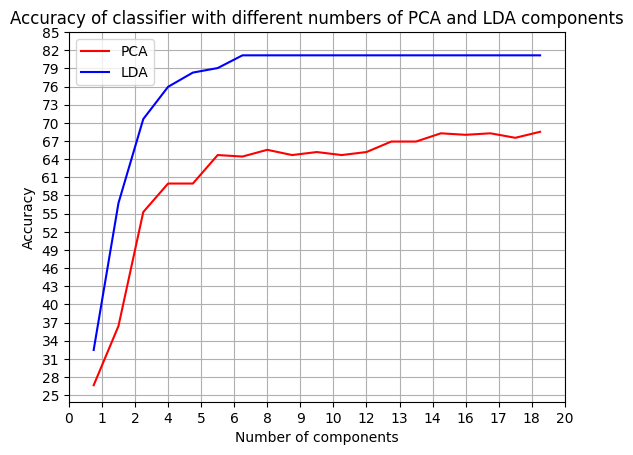

In [24]:
#plot results of accuracy output of test_pca and test_lda function changing the n_components
# Test different values of n_components
accuracies_pca = []
accuracies_lda = []

n_components_values = range(1, 20)
for n_components in n_components_values:
    accuracy_pda = test_pca(train_labels, test_labels, visual_words, visual_words_test, n_components, plot_prints=False)
    if n_components <= 8 - 1: #nclasses = 8
        accuracy_lda = test_lda(train_labels, test_labels, visual_words, visual_words_test, min(n_components, 8 - 1), plot_prints=False) #nclasses = 8
    else:
        accuracy_lda= accuracies_lda[-1]
    accuracies_pca.append(accuracy_pda)
    accuracies_lda.append(accuracy_lda)

# Plot the results
plt.plot(n_components_values, accuracies_pca, color='red', label='PCA')
plt.plot(n_components_values, accuracies_lda, color='blue', label='LDA')

plt.xlabel("Number of components")
xticks = np.linspace(0, 20, 16)
xlabels = [str(int(xtick)) for xtick in xticks]
plt.xticks(xticks, xlabels)

plt.ylabel("Accuracy")
yticks = np.linspace(25, 85, 21)
ylabels = [str(int(ytick)) for ytick in yticks]
plt.yticks(yticks, ylabels)

plt.legend()

plt.title("Accuracy of classifier with different numbers of PCA and LDA components")
plt.grid()
plt.show()

**Play with reducing dimensionality. Conclusions?**

Linear Discriminant Analysis (LDA) and Probabilistic Discriminant Analysis (PDA) are both methods that can be used to reduce the dimensionality of data in an image classification problem. LDA and PDA both try to find a set of dimensions that are most informative for distinguishing between different classes in the data.

LDA has proven to be the best method in our case. This is likely because it was able to find a set of dimensions that were more effective at discriminating between the different classes in our data. This may be because LDA was able to capture more of the underlying structure of the data, or because it was able to better separate the different classes in the lower-dimensional space.

From the previous graph, we can see that LDA works better with the lda_components set to the maximum possible (number of classes), which is 7. PDA has also shown to reach almost the peak accuracy around 7 components, slightly improving if more components were chosen.

Both LDA and PDA were able to improve the accuracy of our classifier (without reducing dimensionality) as they were able to provide a better representation of the data that was more conducive to accurate classification. This could be because the original high-dimensional representation of the data was not very informative or because it contained a lot of noise.

Test different amounts of local features:

In [25]:
des_type = "SIFT"  # "SIFT", "DSIFT", "KAZE", 'ORB', 'AKAZE'
knn_distance = "euclidean"

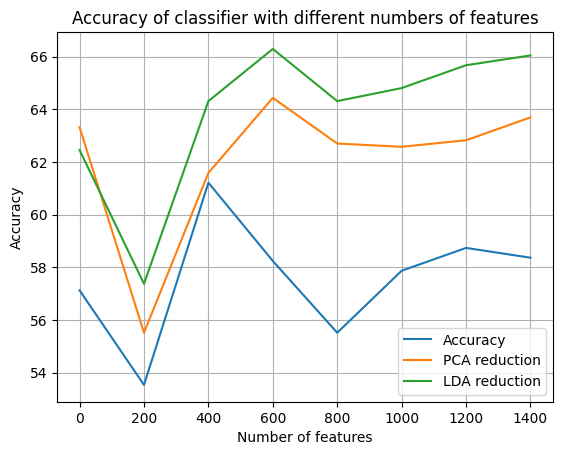

In [31]:
#plot results of accuracy output of chaning the number of features in SIFT
# Test different values of n_components
accuracies = []
lda_accuracies = []
pca_accuracies = []

n_featuresrange = range(0, 1500,200)
for n_features in n_featuresrange:
    acc, pca_acc, lda_acc, visual_words, visual_words_test = train_and_test(plot_matrix=False, plot_prints=False)
    accuracies.append(acc)
    lda_accuracies.append(lda_acc)
    pca_accuracies.append(pca_acc)

# Plot
fig, ax = plt.subplots()

ax.plot(n_featuresrange, accuracies, label='Accuracy')
ax.plot(n_featuresrange, pca_accuracies, label='PCA reduction')
ax.plot(n_featuresrange, lda_accuracies, label='LDA reduction')

ax.set_xlabel("Number of features")
ax.set_ylabel("Accuracy")
plt.title("Accuracy of classifier with different numbers of features")

ax.legend()
plt.grid()
plt.show()

**Test different amounts of local features. What performs best?**

Changing the number of local features detected by SIFT can affect the performance of the algorithm in a these ways:

Matching accuracy: SIFT uses the local features and their corresponding descriptors to match features between images. If the number of features is too small, there may not be enough distinctive points to accurately match the images. On the other hand, if the number of features is too large, the matching process may become computationally expensive and may not provide any additional benefit in terms of matching accuracy.

Computational cost: SIFT is a computationally intensive algorithm, and increasing the number of features will increase the computational cost of the algorithm.

As we can see from the previous graph, we can find the best amount of local features around 600 local features, which is the one that have a better balance between accuracy and computational cost.

Test different codebook sizes:

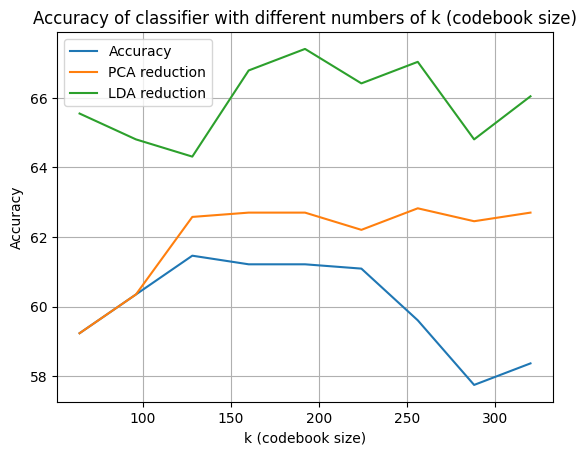

In [32]:
#plot results of accuracy output of chaning the number of features in SIFT
# Test different values of n_components
accuracies = []
lda_accuracies = []
pca_accuracies = []
k_codebook_range = range(64, 350,32)
for k_codebook in k_codebook_range:
    acc, pca_acc, lda_acc, visual_words, visual_words_test = train_and_test(plot_matrix=False, plot_prints=False)
    accuracies.append(acc)
    lda_accuracies.append(lda_acc)
    pca_accuracies.append(pca_acc)

# Plot
fig, ax = plt.subplots()

ax.plot(k_codebook_range, accuracies, label='Accuracy')
ax.plot(k_codebook_range, pca_accuracies, label='PCA reduction')
ax.plot(k_codebook_range, lda_accuracies, label='LDA reduction')

ax.set_xlabel("k (codebook size)")
ax.set_ylabel("Accuracy")
plt.title("Accuracy of classifier with different numbers of k (codebook size)")

ax.legend()
plt.grid()
plt.show()

**Test different amounts of codebook sizes k. What performs best?**

The codebook size determines the size of the set of words that the algorithm uses to represent the images. The larger the codebook the more words used to represent the image and as a result a more accurate representation should be achieved, but it may take longer to process.

In this case, using SIFT descriptors, we see how it tends to achieve a better accuracy the larger the codebook, although in the case of no dimensionality reduction the occurrence is always very similar.

Test different k for the k-nn classifier:


In [33]:
#plot results of accuracy output of chaning the number of features in SIFT
# Test different values of n_components
accuracies = []
lda_accuracies = []
pca_accuracies = []
k_knn_range = range(1,20)
for n_neighbours in k_knn_range:
    acc, pca_acc, lda_acc, visual_words, visual_words_test = train_and_test(plot_matrix=False, plot_prints=False)
    accuracies.append(acc)
    lda_accuracies.append(lda_acc)
    pca_accuracies.append(pca_acc)

# Plot
fig, ax = plt.subplots()

ax.plot(k_knn_range, accuracies, label='Accuracy')
ax.plot(k_knn_range, pca_accuracies, label='PCA reduction')
ax.plot(k_knn_range, lda_accuracies, label='LDA reduction')

ax.set_xlabel("k (nearest neighbours)")
ax.set_ylabel("Accuracy")
plt.title("Accuracy of classifier with different numbers of k (nearest neighbours)")

ax.legend()
plt.grid()
plt.show()

**Test different values of k for the k-nn classifier. What performs best?**

The optimal value of k can depend on the characteristics of the dataset and the specific classification task. In general, a small value of k (e.g., k=1) may be more prone to overfitting, while a larger value of k (e.g., k=5 or k=10) may be more resistant to overfitting but may be less sensitive to the individual patterns in the data.

In our case, the number of k of the k-nn classifier that performs the best, and avoids underfitting and overfitting, could be k=15 for example.
